In [1]:
# This is a fix for vscode, because it doesn't like my
# julia docstrings for whatever reason, and throws a `Katex` error.
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [2]:
using BenchmarkTools;
using CUDA
using Base: @doc
using Revise
using Fmt: @f_str, format # Python-style f-strings
using Random: shuffle, randperm

push!(LOAD_PATH, "../../../src");
using Pose2D
using Geometry: Segment
using MyUtils
using Raycaster
using SensorDistributions;

In [3]:
using Colors, Plots, Images;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using Fmt: @f_str, format # Python-style f-strings
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src");
using GenDistributionZoo: ProductDistribution

const diagnormal = broadcasted_normal

mvuniform = ProductDistribution(uniform);
include("../../../src/house_expo_utils.jl");

## Load Environment

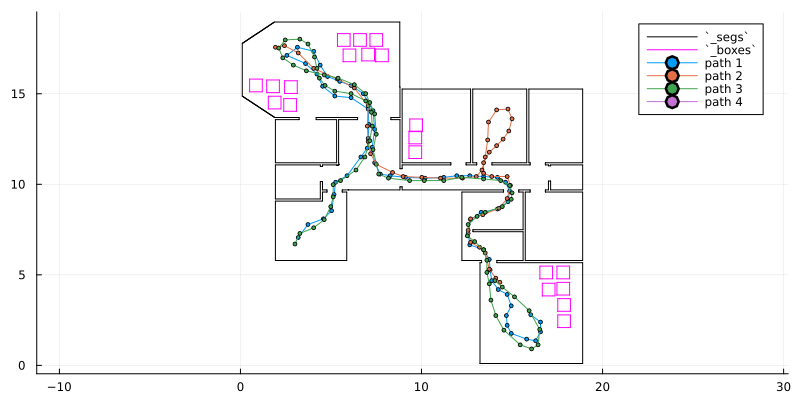

In [4]:


fname = "../data/task_inputs/test_env_2.json"
_segs, _boxes, _paths = load_env(fname)
_bb = bounding_box(_segs)

# ----------------
mypl = plot(size=(800, 400), aspect_ratio=:equal)
plot!(_segs, c=:black, label="`_segs`")
plot!(_boxes, c=:magenta, label="`_boxes`")
for (i,xs) in enumerate(_paths)
    plot!(xs, marker=:o, markersize=2, c=col[i], label="path $i")
end
mypl

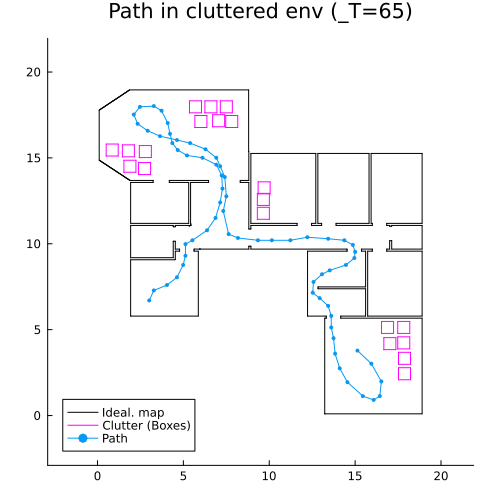

In [5]:
_ps, _us = unpack_path(_paths[3])
_T = length(_ps)

# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Path in cluttered env (_T=$_T)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(Pose2D.position.(_ps), c=col[1], marker=:o, markersize=2, markerstrokewidth=0, linewidth=1, label="Path")
mypl

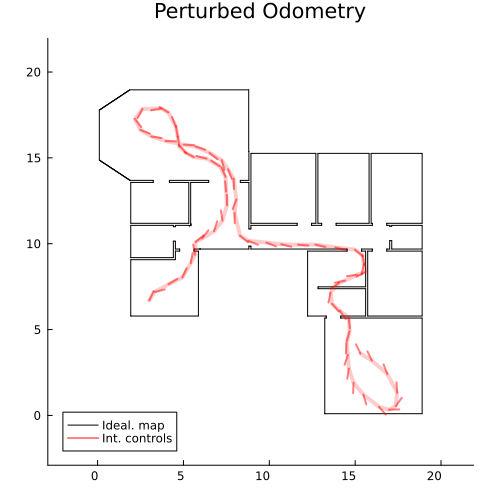

In [6]:
#nbx
x_noise  = 0.1
hd_noise = 5/360*2π
us_noisy = perturb.(_us, x_noise, hd_noise);

rel_ps = [p+u for (p,u) in zip(_ps[1:end-1],us_noisy)];
ps_noisy = [_ps[1]]
for u in us_noisy
    push!(ps_noisy, ps_noisy[end] + u)
end

# -----------------
env_plt = plot(
    size=(500,500), aspect_ratio=:equal, title="Perturbed Odometry", axis=true, grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!([p.x for p in ps_noisy], c=:red, label=nothing, alpha=0.2, linewidth=4)

plot!(ps_noisy[[1]],     c=:red,  r=.6, label="Int. controls", alpha=0.5, linewidth=2)
plot!(ps_noisy[2:end], c=:red,  r=.6,  label=nothing,  alpha=0.5, linewidth=2)
env_plt

In [7]:
#nbx
"""
    zs, _as, ys = create_observations(ps::Vector{Pose}, segs, fov, num_a, obs_noise=0.0)
    
Return depth measurements `zs` and the angles `_as` along which the measuremnts were taken, 
and their 2D point cloud version `ys` for a given set of poses `ps` and a map `segs` of line
segments.

Example:
```julia
    _obs_noise = 0.1
    _fov       = 2π
    _num_a     = 361
    _zs, _as, _ys   = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)
```
"""
function create_observations(ps::Vector{Pose}, segs, fov, num_a, obs_noise=0.0)
    segs = stack(Vector.(segs));
    ps   = stack(Vector.(ps));

    zs  = cast(ps, segs; fov=fov, num_a=num_a)
    zs += _obs_noise * randn(size(zs))
    zs  = unstack(zs);

    as  = [range(-fov/2, fov/2, _num_a)...];
    ys  = [polar_inv(z,as) for z in zs]
    return zs, as, ys
end

create_observations

In [8]:
#nbx
_obs_noise = 0.1
_fov       = 2π
_num_a     = 100

# Todo: This should be computed in the data file, but 
#       it also depens on `fov` so ...whatever
_zs, _as, _ys = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)

# -------------
println("Created a few new variables:\n")
summarize_vars(:(_obs_noise, _fov, _as, _zs, _ys))
println("")

Created a few new variables:



_obs_noise Float64
_fov       Float64
_as        Vector{Float64}
_zs        Vector{Vector{Float64}}
_ys        Vector{Vector{Vector{Float64}}}



[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/tmp.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/tmp.gif")
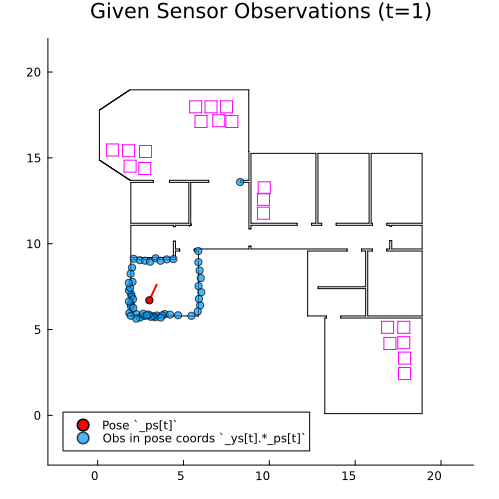

In [11]:
# -----------------------
ani = Animation()
for t=1:1:_T
    p = _ps[t]
    y = _ys[t]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Given Sensor Observations (t=$t)", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!(_boxes, c=:magenta, label=nothing)
    plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([p.x], c=:red, label="Pose `_ps[t]`")
    scatter!(shuffle(y[1:2:end]).*p, c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")
    frame(ani, agent_plt)
end
# gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
gif(ani, fps=4)

In [10]:
include("../../../src/grid_proposals.jl")

# function eval_pose_vectors2(
#     vs   :: Array{Vector{Float64}},
#     z    :: Vector{Float64},
#     segs :: Vector{Segment},
#     fov, num_a, w::Int,
#     sig, outlier,
#     zmax::Float64=50.0; 
#     sorted=false, return_outliermap=false)

#     # Compute sensor measurements and
#     # Gaussian mixture components
#     # p_  = CuArray(Vector(p))
#     # ps_ = reshape(p_, 1, 3)

#     ps   = stack(vs[:])
#     segs = stack(Vector.(segs))
#     as   = create_angles(fov, num_a)

#     if _cuda[]
#         ps   = CuArray(ps)
#         z    = CuArray(z)
#         segs = CuArray(segs)
#         as   = CuArray(as)
#         if sig isa Vector
#             sig = CuArray(sig)
#         end
#         if outlier isa Vector
#             outlier = CuArray(outlier)
#         end
#     end

#     # Clip the measurements at zero and the maximum
#     z = clamp.(z, 0.0, zmax)

#     zs = cast(ps, segs; fov=fov, num_a=num_a, zmax=zmax)
#     ỹ, d̃ = get_1d_mixture_components(zs, as, w);

#     # Evaluate the the observations with respect to the
#     # different Gaussian mixtures computed above
#     log_ps, _, outl = depthdist_logpdf(z, ỹ, d̃, sig, outlier, zmax;
#                         scale_noise=false, 
#                         return_pointwise=false, 
#                         return_outliermap=return_outliermap);

#     # Move everyting back to CPU if is not already there
#     log_ps = Array(log_ps)

#     # Sort by log prob
#     # and return
#     # if sorted
#     # perm   = sortperm(log_ps)
#     # log_ps = log_ps[perm]
#     # vs     = vs[:][perm]
#     # end

#     return log_ps, outl
# end;

(10, 10, 10)


 54.802956 seconds (100.17 M allocations: 5.114 GiB, 4.15% gc time, 75.50% compilation time)
(1000, 10, 10)(

1000, 100, 10, 10)


CartesianIndex(444, 1, 7)
maximum log prob: 

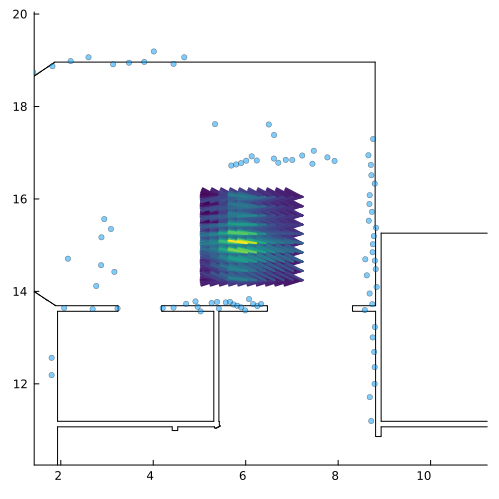

-82.45796401354288


In [11]:
t = 15
z = _zs[t]
p0 = _ps[t] + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 10/180*π))

v0 = Vector(p0)
grid_args = (
    k = [10, 10, 10],
    r = [.2, .2, 5/180*π],
)


vs, = vector_grid(v0, grid_args...)

println(size(vs))


w       = 10
sig     = range(0.1, 1., 10)
outlier = range(0.01, 0.4, 10)
zmax    = 25.

@time log_ps, outl = eval_pose_vectors2(vs, z, _segs, _fov, _num_a, w, sig, outlier, zmax; sorted=false)

println(size(log_ps), size(outl))
i = argmax(log_ps)
println(i)
x = polar_inv(z, _as)

println("maximum log prob: ", maximum(log_ps))
vals = log_ps[:,i[2],i[3]]
perm = sortperm(vals)
vals = vals[perm]

# -----------------------------
delta = 4
mypl = plot(size=(500,500), legend=nothing, aspect_ratio=:equal,  grid=false, showaxis = true,
    xlim=(vs[1][1]-delta, vs[end][1]+delta),
    ylim=(vs[1][2]-delta, vs[end][2]+delta) 
)
plot!(_segs, c=:black)
cs = cgrad(:viridis)[peak_to_peak(vals)]
plot!(Pose.(vs[perm]), cs, r=.4, linewidth=2)
scatter!(x .* Pose(vs[i[1]]), markerstrokewidth=0.5, c=col[1], alpha=0.5, markersize=3)
display(mypl)


In [20]:
# m = dropdims(maximum(log_ps, dims=1), dims=1)
m = dropdims(log.(sum(exp.(log_ps .- log(sum(exp.(log_ps)))), dims=1)), dims=1)

10×10 Matrix{Float64}:
 -64.0647  -24.3174  -12.3027   -6.23897  …   -1.46242   -2.74919   -4.73453
 -83.491   -47.9395  -37.2725  -32.0213      -28.9548   -30.506    -32.7198
 -93.4882  -65.8465  -57.5762  -53.6813      -53.0808   -54.9414   -57.398
 -93.1844  -73.8157  -68.1614  -65.7927      -68.2132   -70.5094   -73.3316
 -73.6697  -73.9096  -72.303   -71.5952      -77.3661   -80.1618   -83.4081
 -58.6924  -61.5098  -64.5251  -67.7243   …  -81.6786   -85.3484   -89.2321
 -53.4116  -56.7977  -60.3242  -64.0018      -80.4802   -85.1187   -90.0006
 -52.8834  -56.4426  -60.1401  -63.9872      -81.1532   -85.9779   -91.061
 -54.7298  -58.3447  -62.0984  -66.0024      -83.4004   -88.2843   -93.4273
 -57.7258  -61.3518  -65.1163  -69.0304      -86.4591   -91.3467   -96.4911

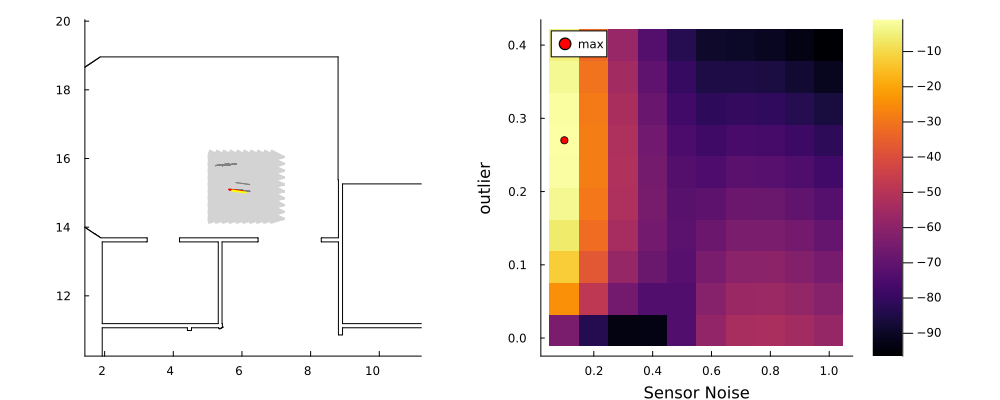

In [21]:
# m = dropdims(maximum(log_ps, dims=1), dims=1)
I = dropdims(argmax(log_ps, dims=1), dims=1)
imax = argmax(log_ps)

# -----------------------------
plot_1 = plot(size=(600,400), title="",
    grid=false, xlabel="Sensor Noise", ylabel="outlier", right_margin = 10Plots.mm
)
heatmap!(sig, outlier, m')
scatter!([sig[imax[2]]],outlier[[imax[3]]], label="max", c=:red)

# -----------------------------
plot_2 = plot(size=(500,500), legend=nothing, aspect_ratio=:equal,  grid=false, showaxis = true,
xlim=(vs[1][1]-delta, vs[end][1]+delta),
ylim=(vs[1][2]-delta, vs[end][2]+delta) 
)
plot!(_segs, c=:black)

plot!(Pose.(vs[:]), c=:lightgray, r=.4, linewidth=2)
for i in I
    plot!(Pose(vs[i[1]]), r=.4, c=:gray, linewidth=1)
end
plot!(Pose(vs[imax[1]]), r=.4, c=:red, linewidth=2)
plot!(_ps[t], r=.4, c=:yellow, linewidth=2)

# -----------------------------
plot(plot_2, plot_1, layout=(1,2), size=(1000,400), margin=3Plots.mm)


  0.032364 seconds (2.96 k allocations: 2.234 MiB)
  0.036106 seconds (3.06 k allocations: 2.243 MiB)
  0.240718 seconds (28.41 k allocations: 3.559 MiB, 33.16% gc time, 50.22% compilation time)
  0.029826 seconds (3.06 k allocations: 2.244 MiB)
  0.068043 seconds (3.32 k allocations: 2.251 MiB, 52.37% gc time)
  0.029931 seconds (3.06 k allocations: 2.243 MiB)
  0.029878 seconds (3.06 k allocations: 2.244 MiB)
  0.064692 seconds (3.42 k allocations: 2.255 MiB, 48.70% gc time)
  0.029892 seconds (3.06 k allocations: 2.243 MiB)
  0.060689 seconds (3.38 k allocations: 2.255 MiB, 46.49% gc time)
  0.029833 seconds (3.06 k allocations: 2.243 MiB)
  0.048493 seconds (3.37 k allocations: 2.254 MiB, 32.67% gc time)
  0.029934 seconds (3.06 k allocations: 2.243 MiB)
  0.029886 seconds (3.06 k allocations: 2.243 MiB)
  0.051537 seconds (3.38 k allocations: 2.253 MiB, 35.46% gc time)
  0.029904 seconds (3.06 k allocations: 2.243 MiB)
  0.048645 seconds (3.38 k allocations: 2.255 MiB, 33.27% gc t

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/hierarchical_sensor.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/hierarchical_sensor.gif")
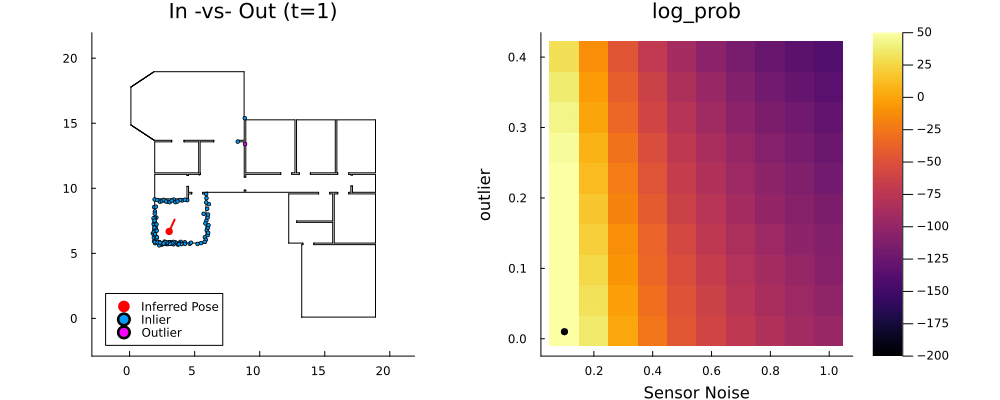

In [15]:

q = _ps[1] + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 10/180*π))
qs = []
ani = Animation()
for t=1:30

    z = _zs[t]
    y = _ys[t]

    v0 = Vector(q)
    grid_args = (
        k = [9, 9, 31],
        r = [.2, .2, 1/180*π],
    )

    vs, = vector_grid(v0, grid_args...)

    w       = 10
    sig     = range(0.1, 1., 10)
    outlier = range(0.01, 0.4, 10)
    zmax    = 25.

    @time log_ps,outl = eval_pose_vectors2(vs, z, _segs, _fov, _num_a, w, sig, outlier, zmax; sorted=false)

    log_ps = Array(log_ps)
    outl = Array(outl)

    q = Pose(vs[argmax(log_ps)[1]])
    push!(qs, q)
    
    m = dropdims(maximum(log_ps, dims=1), dims=1)
    I = dropdims(argmax(log_ps, dims=1), dims=1)
    imax = argmax(log_ps)

    # -----------------------------
    agent_plot = plot(
        size=(500,500), aspect_ratio=:equal, title="In -vs- Out (t=$t)", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    # plot!(_boxes, c=:magenta, label=nothing)
    plot!([q], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([q.x], c=:red,  markerstrokewidth=0, label="Inferred Pose")
    scatter!(shuffle(y[.!outl[imax[1],:,imax[2],imax[3]]]).*q, c=col[1], markersize=2, alpha=1., markerstrokewidth=1, label="Inlier")
    scatter!(shuffle(y[outl[imax[1],:,imax[2],imax[3]]]).*q, c=:magenta, markersize=2, alpha=1., markerstrokewidth=1, label="Outlier")
    # -----------------------------
    heat_plot = plot(size=(600,400), title="log_prob",
        grid=false, xlabel="Sensor Noise", ylabel="outlier", right_margin = 10Plots.mm
    )
    heatmap!(sig, outlier, m', clim=(-200,50))
    scatter!([sig[imax[2]]],outlier[[imax[3]]], label=nothing, c=:black)
    # -----------------------------
    frame(ani, plot(agent_plot, heat_plot, layout=(1,2), size=(1000,400), margin=3Plots.mm))


    q = q + _us[t] + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 7/180*π))
end
gif(ani, "_imgs/hierarchical_sensor.gif", fps=5)
# gif(ani, fps=5)

# Version 2

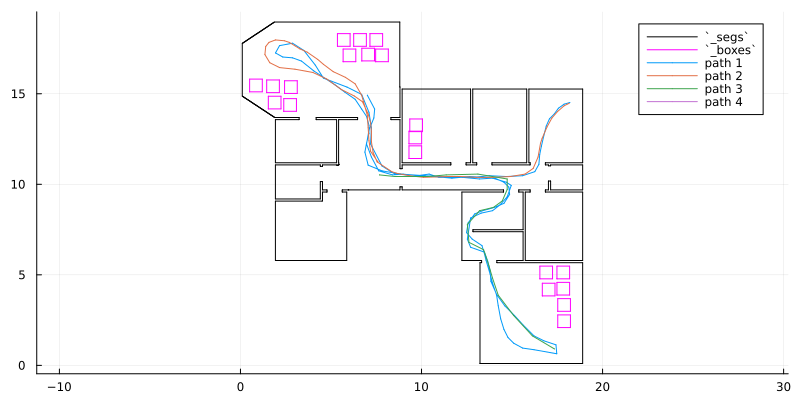

In [16]:
fname = "../data/task_inputs/test_env_3.json"
_segs, _boxes, _paths = load_env(fname)
_bb = bounding_box(_segs)

# ----------------
mypl = plot(size=(800, 400), aspect_ratio=:equal)
plot!(_segs, c=:black, label="`_segs`")
plot!(_boxes, c=:magenta, label="`_boxes`")
for (i,xs) in enumerate(_paths)
    plot!(xs, marker=:o, markersize=0, c=col[i], label="path $i")
end
mypl

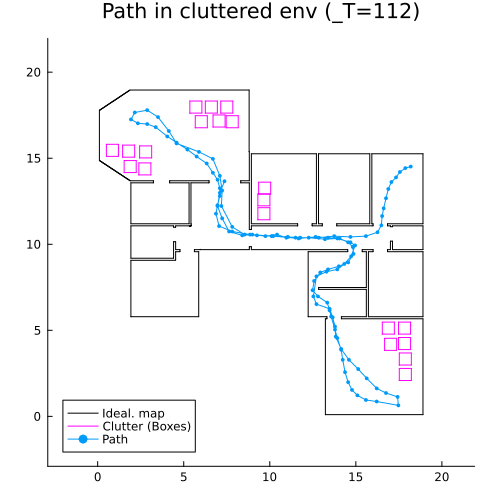

In [24]:
_ps, _us = unpack_path(_paths[1])
_T = length(_ps)

# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Path in cluttered env (_T=$_T)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(Pose2D.position.(_ps), c=col[1], marker=:o, markersize=2, markerstrokewidth=0, linewidth=1, label="Path")
mypl

In [25]:
#nbx
_obs_noise = 0.2
_fov       = 2π
_num_a     = 200

# Todo: This should be computed in the data file, but 
#       it also depens on `fov` so ...whatever
_zs, _as, _ys = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)

([[0.7903681825971732, 0.7373185001286686, 0.9740528165709905, 0.8204246027868201, 0.801543029579992, 0.7091910112830369, 0.4835991735517874, 0.7441701034503017, 0.8866935093303823, 1.2032174272997957  …  1.0786995775900818, 0.7663516600496548, 0.7798416264550465, 0.9344902860068284, 1.0111555317694914, 0.8907599216630776, 1.003878968320745, 0.874787483604122, 0.8300540512130734, 0.41869152845068686], [1.0902890519298325, 1.0647263103766766, 1.351109521163864, 0.995107425305812, 1.3582435719872046, 1.355295469441266, 1.2226245890619127, 1.3878980550717956, 1.0993734527361532, 0.8409230517442038  …  0.886322243332252, 1.2957934877477173, 1.110521915275235, 0.8994122398650854, 1.1767845872897271, 1.0799671059126665, 0.96698672359182, 1.298468958739195, 1.1698874865994815, 1.158917711637565], [1.4453142245788269, 1.0558391382815706, 1.147213292914524, 1.349840339249961, 1.3288945728711408, 1.0232214995781617, 1.3290820376047445, 1.1440889482034757, 0.8329952191414682, 1.2289819555947463  

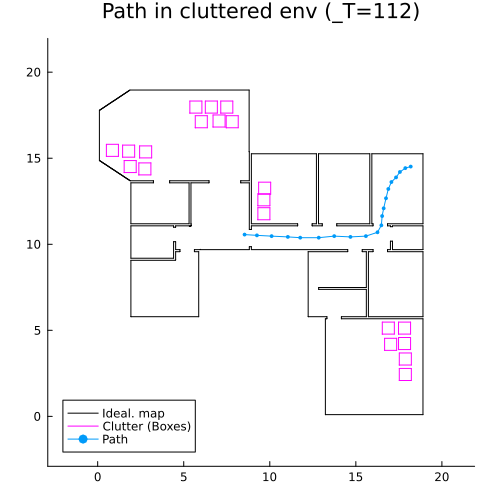

In [26]:
ts1 = 1:20

_ps, _us = unpack_path(_paths[1])
_T = length(_ps)

# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Path in cluttered env (_T=$_T)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(Pose2D.position.(_ps[ts1]), c=col[1], marker=:o, markersize=2, markerstrokewidth=0, linewidth=1, label="Path")
mypl

In [ ]:

q = _ps[1] + Control([-4;0], 0) + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 10/180*π))
qs = []
ani = Animation()
for t=1:20

    z = _zs[t]
    y = _ys[t]

    v0 = Vector(q)

    grid_args = (
        k = [5, 5, 5],
        r = [.2, .2, 2/180*π],
    )

    vs, = vector_grid(v0, grid_args...)

    w       = 10
    sig     = range(0.1, 1., 10)
    outlier = range(0.01, 0.4, 10)
    zmax    = 25.

    @time log_ps,outl = eval_pose_vectors2(vs, z, _segs, _fov, _num_a, w, sig, outlier, zmax; sorted=false)

    log_ps = Array(log_ps)
    outl = Array(outl)

    q = Pose(vs[argmax(log_ps)[1]])
    push!(qs, q)
    
    m = dropdims(maximum(log_ps, dims=1), dims=1)
    I = dropdims(argmax(log_ps, dims=1), dims=1)
    imax = argmax(log_ps)

    # -----------------------------
    agent_plot = plot(
        size=(500,500), aspect_ratio=:equal, title="In -vs- Out (t=$t)", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    # for j=1:5:length(y)
    for yy in y[.!outl[imax[1],:,imax[2],imax[3]]]
        plot!([zeros(2), yy].*q, c=col[1], alpha=0.1, label=nothing)
    end
    for yy in y[outl[imax[1],:,imax[2],imax[3]]]
        plot!([zeros(2), yy].*q, c=:magenta, alpha=0.1, label=nothing)
    end

    plot!(_segs, c=:black, linewidth=1, label=nothing)
    # plot!(_boxes, c=:magenta, label=nothing)
    plot!([q], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([q.x], c=:red,  markerstrokewidth=0, label="Inferred Pose")
    
    scatter!(shuffle(y[.!outl[imax[1],:,imax[2],imax[3]]]).*q, c=col[1], markersize=2, alpha=1., markerstrokewidth=1, label="Inlier")
    scatter!(shuffle(y[outl[imax[1],:,imax[2],imax[3]]]).*q, c=:magenta, markersize=2, alpha=1., markerstrokewidth=1, label="Outlier")

    # -----------------------------
    heat_plot = plot(size=(600,400), title="log_prob",
        grid=false, xlabel="Sensor Noise", ylabel="outlier", right_margin = 10Plots.mm
    )
    heatmap!(sig, outlier, m', clim=(-200,50))
    scatter!([sig[imax[2]]],outlier[[imax[3]]], label=nothing, markersize=10, c=:white)
    # -----------------------------
    frame(ani, plot(agent_plot, heat_plot, layout=(1,2), size=(1000,400), margin=3Plots.mm))


    q = q + _us[t] + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 7/180*π))
end
gif(ani, "_imgs/kidnap_1.gif", fps=2)
# gif(ani, fps=5)

# Version 3

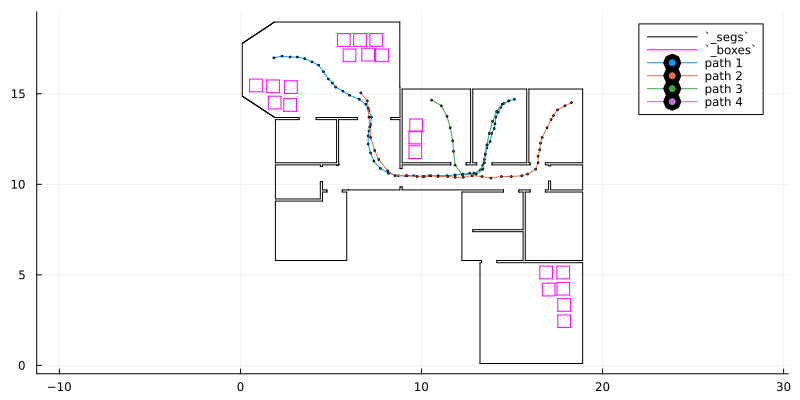

In [22]:
fname = "../data/task_inputs/test_env_4.json"
_segs, _boxes, _paths = load_env(fname)
_bb = bounding_box(_segs)

# ----------------
mypl = plot(size=(800, 400), aspect_ratio=:equal)
plot!(_segs, c=:black, label="`_segs`")
plot!(_boxes, c=:magenta, label="`_boxes`")
for (i,xs) in enumerate(_paths)
    plot!(xs, marker=:o, markersize=1, c=col[i], label="path $i")
end
mypl

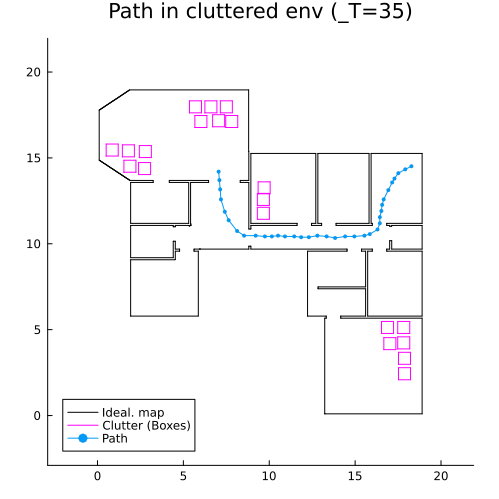

In [23]:
_ps, _us = unpack_path(_paths[2])
_T = length(_ps)

# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Path in cluttered env (_T=$_T)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(Pose2D.position.(_ps), c=col[1], marker=:o, markersize=2, markerstrokewidth=0, linewidth=1, label="Path")
mypl

In [24]:
#nbx
_obs_noise = 0.1
_fov       = 2π
_num_a     = 100

# Todo: This should be computed in the data file, but 
#       it also depens on `fov` so ...whatever
_zs, _as, _ys = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)
# _zs, _as, _ys = create_observations(_ps, _segs, _fov, _num_a, _obs_noise)

([[0.7463252052561192, 0.7411467354981971, 0.6706806619823057, 0.8903808674236655, 0.8434239043618679, 0.8555591803489824, 0.9480522912687682, 0.8715831882081756, 0.8735050824523569, 0.8013053221440705  …  0.6455864050192643, 0.7327006186922898, 0.5152908771842637, 0.8266158400175243, 0.7033575718301299, 0.5418811653410204, 0.5407423830149692, 0.6192136147735723, 0.7976094044122494, 0.6571804452882372], [1.124975960297726, 1.329308426409637, 1.2361883700761658, 1.175209111438386, 1.4281377881121544, 1.275595243276422, 1.199347160552292, 1.2445198773987785, 1.2058032749075296, 0.8881529022047477  …  0.9423046199872446, 1.0012520255872805, 1.0149400384435987, 0.9500104942513717, 1.1543409592285248, 0.9307447687764112, 1.015879723703129, 1.1158638571948754, 1.1032278674596379, 0.9970181402512075], [1.4660857921975554, 1.396511155207655, 1.3698140082454293, 1.3629809662041485, 1.1729158204218693, 1.1252300163828093, 1.1044499000392591, 1.0944585014248456, 1.132185574146321, 1.1571204768692

In [25]:
t1 = 1
q = _ps[t1] + Control([-4;0], 0)
# q = _ps[t1]
qs = []
ani = Animation()

grid_args = (
    k = [21, 21, 21],
    r = [.1, .1, 2/180*π],
)

confused = false

t=t1
# while t < 6
while t < _T
# for t=1:_T

    z = _zs[t]
    y = _ys[t]

    v0 = Vector(q)

    # grid_args = (
    #     k = [11, 11, 11],
    #     r = [.1, .1, 2/180*π],
    # )

    vs, = vector_grid(v0, grid_args...)

    w       = 10
    sig     = range(0.1, 1., 12)
    outlier = range(0.01, 0.4, 12)
    zmax    = 25.

    @time log_ps,outl = eval_pose_vectors2(vs, z, _segs, _fov, _num_a, w, sig, outlier, zmax; sorted=false)

    log_ps = Array(log_ps)
    outl = Array(outl)

    q = Pose(vs[argmax(log_ps)[1]])
    push!(qs, q)
    
    # m = dropdims(maximum(log_ps, dims=1), dims=1)
    m = dropdims(log.(sum(exp.(log_ps .- log(sum(exp.(log_ps)))), dims=1)), dims=1)
    I = dropdims(argmax(log_ps, dims=1), dims=1)
    imax = argmax(log_ps)

    if sig[imax[2]] < 0.6 
        confused = false
    else 
        confused = true
    end



    #############################################
    #
    #       External World Simulation
    #
    #############################################
    agent_plot2 = plot(
        size=(500,500), aspect_ratio=:equal, title="External World\nSimulation", grid=false, axis=true,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )


    c = :green

    for yy in y[1:1:end]
        plot!([zeros(2), yy].*_ps[t], c=c, alpha=0.05, label=nothing)
    end

    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!(_boxes, c=:black, label=nothing)
    scatter!(shuffle(y).*_ps[t], c=c, markersize=2, alpha=.4, markerstrokewidth=0, label="Observation")


 
    # c = :darkgreen
    


    
    c = :black
    plot!([_ps[t]], c=c, r=1.0, linewidth=2, label=nothing)
    scatter!([_ps[t].x], c=c,  markerstrokewidth=0, label="Actual Pose")
    
    # scatter!(shuffle(y[outl[imax[1],:,imax[2],imax[3]]]).*q, c=:magenta, markersize=2, alpha=.5, markerstrokewidth=0, label="Outlier")



    # s =(sig[imax[2]] - sig[1])/sig[end] 
    # c = RGBA(1,0,0, s)
    # # c = cgrad(:berlin)[s] 
    # annotate!(10,20, text("NOISE!", 12, c, :left))



    # s = (outlier[imax[3]] - outlier[1])/outlier[end]
    # c = cgrad(:berlin)[s] 
    # c = RGBA(1,0,0, s)
    # annotate!(16,20, text("OUTLIERS!", 12, c, :left))

    #############################################
    #
    #       Internal World Model
    #
    #############################################
    agent_plot1 = plot(
        size=(500,500), aspect_ratio=:equal, title="Internal World\nModel", grid=false, axis=true,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )

    for yy in y[.!outl[imax[1],:,imax[2],imax[3]]]
        plot!([zeros(2), yy].*q, c=col[1], alpha=0.1, label=nothing)
    end
    for yy in y[outl[imax[1],:,imax[2],imax[3]]]
        plot!([zeros(2), yy].*q, c=:magenta, alpha=0.1, label=nothing)
    end

    plot!(_segs, c=:black, linewidth=1, label=nothing)
    # plot!(_boxes, c=:magenta, label=nothing)

    # plot!([q.x,_ps[t].x], c=:lightgray, alpha=.5, linewidth=3, label=nothing)
    # plot!([_ps[t]], c=:lightgray, r=1.0, linewidth=2, label=nothing)
    # scatter!([_ps[t].x], c=:lightgray,  markerstrokewidth=0, label="Actual Pose")


    # plot!([q.x,_ps[t].x], c=:lightgray, alpha=.2, linewidth=3, label=nothing)
    # plot!([_ps[t]], c=:lightgray, r=1.0, linewidth=2, label=nothing)
    # scatter!([_ps[t].x], c=:lightgray,  markerstrokewidth=0, label="Actual Pose")

    if confused
        plot!([q], c=:red, r=1.0, linewidth=2, label=nothing)
        scatter!([q.x], c=:red,  markerstrokewidth=0, label="Inferred Pose")
    else
        plot!([q], c=:black, r=1.0, linewidth=2, label=nothing)
        scatter!([q.x], c=:black,  markerstrokewidth=0, label="Inferred Pose")
    end
    
    scatter!(shuffle(y[.!outl[imax[1],:,imax[2],imax[3]]]).*q, c=col[1], markersize=2, alpha=.5, markerstrokewidth=0, label="Inlier")
    scatter!(shuffle(y[outl[imax[1],:,imax[2],imax[3]]]).*q, c=:magenta, markersize=2, alpha=.5, markerstrokewidth=0, label="Outlier")




    s =(sig[imax[2]] - sig[1])/sig[end] 
    c = RGBA(1,0,0, s)
    # c = cgrad(:berlin)[s] 
    annotate!(10,17, text("Confusion", 12, c, :left))



    #########################
    #
    #       HEATMAP
    #
    #########################
    heat_plot = plot(size=(600,400), title="Data\nLikelihood", 
        # aspect_ratio=:equal, 
        # legend_position=:topright, 
        legend_font_size=4,
        # legend = :outertopright,
        legend = false,
        grid=false, 
        # xlabel="Expected\nInlier Tolerance", 
        # ylabel="Probability\nof Outlier",
        # right_margin = 10Plots.mm, bottom_margin = 10Plots.mm,
        yguidefontrotation=-90, yguidefontvalign = :top,
        ylim = (outlier[1]-0.1,outlier[end]+0.05),
        xlim = (sig[1]-0.1,1.3),
        xticks= (sig[1:2:end], [f"{$(ss):0.1f}" for ss in sig[1:2:end] ] ),

    )
    Plots.gr_cbar_width[] = 0.01
    heatmap!(sig, outlier, m', 
        aspect_ratio=:equal, 
        cbar=false,
        # color = cgrad(:thermal),
        # color_ticks=[0,-100],
        # colorbar_ticks=[50,0,-100],
        # cbar_ticks=[50,0,-100],
    ) #, 


    rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])
    # GR.setarrowsize(0.3)
    # plot!(rectangle(0.175,0.2,.8,0.175), c=:white, opacity=1, legend=nothing)
    # plot!([0.85,0.85],[0.21,.35],arrow=(:closed, 1.), color=:black,linewidth=1,label="")

    # plot!(rectangle(0.05,0.025,11.85,0.3), c=cgrad(:plasma)[1.0],opacity=1.,label="High")
    # plot!(rectangle(10,10,11.1,0.4), c=cgrad(:thermal)[.5], linewidth=1, opacity=1.,label="Medium")
    # plot!(rectangle(10,10,11.1,0.4), c=cgrad(:thermal)[0.], linewidth=1, opacity=1.,label="Low")

    hh = 0.03 
    nn = 4
    for (c,yy) in zip(1:-1/nn:0.0, 0.34:-hh:0.34-nn*hh)
        cc = cgrad(:plasma)[c]
        plot!(rectangle(0.075,hh, 1.075, yy), c=cc,  
            linecolor=cc,
            linewidth=0.0,
             opacity=1.)
    end
    scatter!([1.115],[0.315 - 4*hh - hh/2], c=:black)
    plot!([1.1,1.13],[0.33 - 6.5*hh - hh/2,0.33 - 6.5*hh - hh/2], c=:red, linewidth=2)

    # plot!(rectangle(0.05,0.025,1.1,0.3), c=cgrad(:plasma)[1.0],opacity=1.)
    # plot!(rectangle(10,10,11.1,0.4), c=cgrad(:thermal)[.5], linewidth=1, opacity=1.,label="Medium")
    # plot!(rectangle(10,10,11.1,0.4), c=cgrad(:thermal)[0.], linewidth=1, opacity=1.,label="Low")
    
    annotate!(1.2,0.345 + hh/2, text("High", 8, :black, :left, ))
    annotate!(1.2,0.35 - 3*hh - hh/2, text("Low", 8, :black, :left))

    annotate!(1.2,0.315 - 4*hh - hh/2, text("Max", 8, :black, :left))
    annotate!(1.2,0.315 - 6.5*hh - hh/2, text("Confusion\nThreshold", 8, :black, :left))
    
    annotate!(0.,0.55, text("Probability\nof Outlier", 10, :black, :right))
    annotate!(1.,-0.25, text("Expected\nInlier Tolerance", 10, :black, :right))

    scatter!([sig[imax[2]]],[outlier[imax[3]]], label="Max", markersize=2, marker=:o, c=:black)
    plot!([[0.6,-0.05],[0.6,0.45]], c=:red, linewidth=3, label="Confusion\nthreshold"   )
    # -----------------------------

    if t > 2
        frame(ani, plot(agent_plot2,agent_plot1, heat_plot, layout=(1,3), size=(1500,500), margin=5Plots.mm))
    end

    if !confused
        t+=1
        
        grid_args = (
            k = [11, 11, 11],
            r = [.1, .1, 2/180*π],
            )
            u = _us[t-1]
    else 
            # grid_args = (
        #     k = [21, 21, 25],
        #     r = [.3, .3, 2/180*π],
        # )
        grid_args = (
            k = [21, 21, 25],
            r = [.3, .3, 5/180*π],
        )
        u = Control([0;0], 0)
    end
    println(t, " / ", _T)

    q = q + u + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 4/180*π))
end
gif(ani, "_imgs/kidnap_wrong_room_6.gif", fps=2)
# gif(ani, fps=5)

  0.295165 seconds (14.73 k allocations: 11.402 MiB, 21.30% gc time, 24.96% compilation time)


2 / 35
  0.020443 seconds (2.91 k allocations: 1.736 MiB)


3 / 35
  0.019592 seconds (2.91 k allocations: 1.736 MiB)


4 / 35
  0.020556 seconds (2.91 k allocations: 1.736 MiB)


5 / 35


  0.560281 seconds (3.45 k allocations: 1.755 MiB, 95.26% gc time)


6 / 35
  0.019709 seconds (2.91 k allocations: 1.736 MiB)


7 / 35
  0.019753 seconds (2.91 k allocations: 1.736 MiB)


8 / 35
  0.019502 seconds (2.91 k allocations: 1.736 MiB)


9 / 35
  0.082106 seconds (3.41 k allocations: 1.753 MiB, 70.17% gc time)


10 / 35
  0.019883 seconds (2.91 k allocations: 1.736 MiB)


11 / 35
  0.019915 seconds (2.91 k allocations: 1.736 MiB)


12 / 35
  0.019523 seconds (2.91 k allocations: 1.736 MiB)


13 / 35
  0.073952 seconds (3.36 k allocations: 1.750 MiB, 66.08% gc time)


14 / 35
  0.019388 seconds (2.91 k allocations: 1.736 MiB)


15 / 35
  0.019680 seconds (2.91 k allocations: 1.736 MiB)


15 / 35


  0.232224 seconds (3.79 k allocations: 12.791 MiB, 24.59% gc time)


16 / 35
  0.020135 seconds (2.91 k allocations: 1.736 MiB)


17 / 35
  0.019779 seconds (2.91 k allocations: 1.736 MiB)


18 / 35
  0.019690 seconds (2.91 k allocations: 1.736 MiB)


19 / 35
  0.064016 seconds (3.37 k allocations: 1.752 MiB, 62.35% gc time)


20 / 35
  0.019824 seconds (2.91 k allocations: 1.736 MiB)


21 / 35
  0.019605 seconds (2.91 k allocations: 1.737 MiB)


22 / 35
  0.019626 seconds (2.91 k allocations: 1.736 MiB)


23 / 35
  0.059113 seconds (3.36 k allocations: 1.750 MiB, 55.70% gc time)


24 / 35
  0.019742 seconds (2.91 k allocations: 1.736 MiB)


25 / 35
  0.019697 seconds (2.91 k allocations: 1.737 MiB)


26 / 35
  0.019658 seconds (2.91 k allocations: 1.736 MiB)


27 / 35
  0.057048 seconds (3.35 k allocations: 1.750 MiB, 55.82% gc time)


28 / 35
  0.019646 seconds (2.91 k allocations: 1.736 MiB)


29 / 35
  0.019874 seconds (2.91 k allocations: 1.736 MiB)


30 / 35
  0.049972 seconds (3.35 k allocations: 1.751 MiB, 52.34% gc time)


31 / 35
  0.019572 seconds (2.91 k allocations: 1.736 MiB)


32 / 35
  0.019526 seconds (2.91 k allocations: 1.736 MiB)


33 / 35
  0.019698 seconds (2.91 k allocations: 1.736 MiB)


34 / 35
  0.057041 seconds (3.35 k allocations: 1.749 MiB, 57.66% gc time)


35 / 35


/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/dev/v2/_imgs/kidnap_wrong_room_6.gif: No such file or directory


ProcessFailedException: failed process: Process(`/home/ubuntu/.julia/artifacts/b409c0eafb4254a980f9e730f6fbe56867890f6a/bin/ffmpeg -v 16 -framerate 2 -i /tmp/jl_CxhbVi/%06d.png -i /tmp/jl_CxhbVi/palette.bmp -lavfi paletteuse=dither=sierra2_4a -loop 0 -y /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/dev/v2/_imgs/kidnap_wrong_room_6.gif`, ProcessExited(1)) [1]


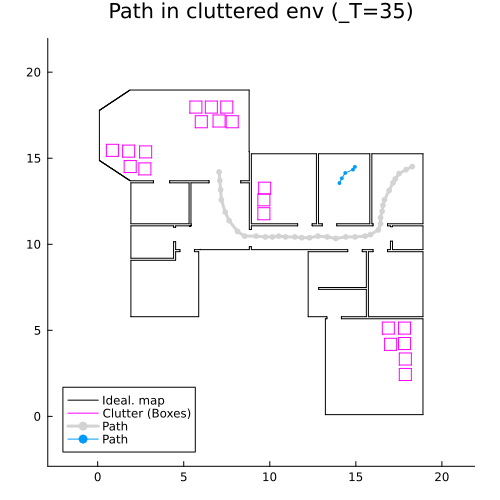

In [24]:
# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Path in cluttered env (_T=$_T)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(Pose2D.position.(_ps), c=:lightgray, marker=:o, markersize=3, markerstrokewidth=0, linewidth=3, label="Path")
plot!(Pose2D.position.(qs), c=col[1], marker=:o, markersize=2, markerstrokewidth=0, linewidth=1, label="Path")
mypl